In [1]:
# Parameters
name = "O_III-5007"


In [2]:
# Parameters
name = "H_I-6563"

In [3]:
import time
start_time=time.time()
from pathlib import Path
import sys
import json
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
# Add path to py_modules 
sys.path.append(str(Path().resolve().parents[1] / 'py_modules')) # 1 level up = project root

# Add path to pipeline_config.py
sys.path.append(str(Path().resolve().parents[0]))  # 1 level up = project root

# Import from pipeline_config and py_modules
from pipeline_config import OBSERVATIONS_DIR

#from io_utils import load_fits
#import strucfunc
#from strucfunc import sosflog
#import bfuncx

In [5]:
# Input FITS files
name_export = name + '_mask'
flux_path    = OBSERVATIONS_DIR / f'linesum-{name}.fits'
radvel_path  = OBSERVATIONS_DIR / f'mean-{name}-patfixx.fits'

# Open files
flux    = fits.open(flux_path)
rad_vel = fits.open(radvel_path)

In [6]:
# Region propertires
dist   = 410   # distance [parsecs]
pix    = 0.2 # spatialscale [arcsec per pixel]

# Observation propertires
seeing = 0.9   # FWHM seeing [arcsec] 

# Conversions
pc = dist * ( 2 * np.pi ) / (360 * 60 * 60) # value in parsecs of each arcsec
s0 = (seeing  * pc) / 2.355 # RMS seeing [parsecs]
pc , s0

(0.0019877360925490972, 0.0007596443665792729)

In [7]:
sb = flux[0].data.astype(float)
vv = rad_vel[0].data.astype(float)

In [8]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

good = (~m) & (sb > 0.001)

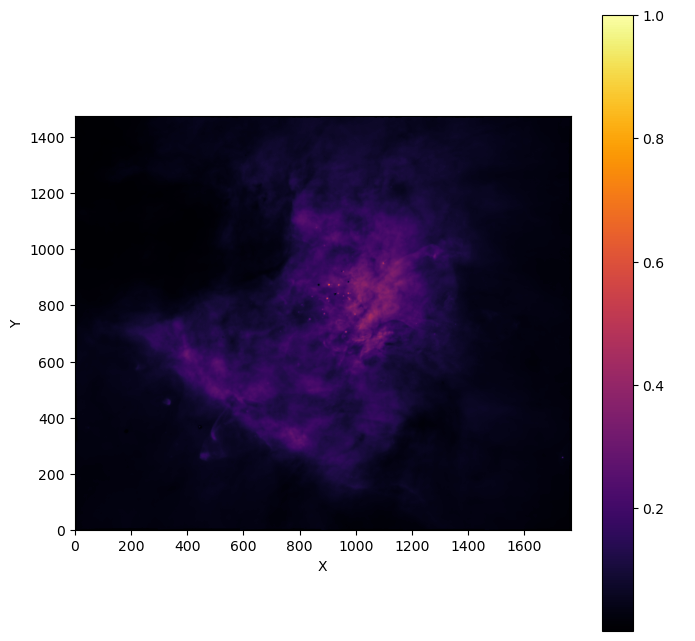

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [10]:
sb_df       = pd.DataFrame(sb)
sb_df       = sb_df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'I'})

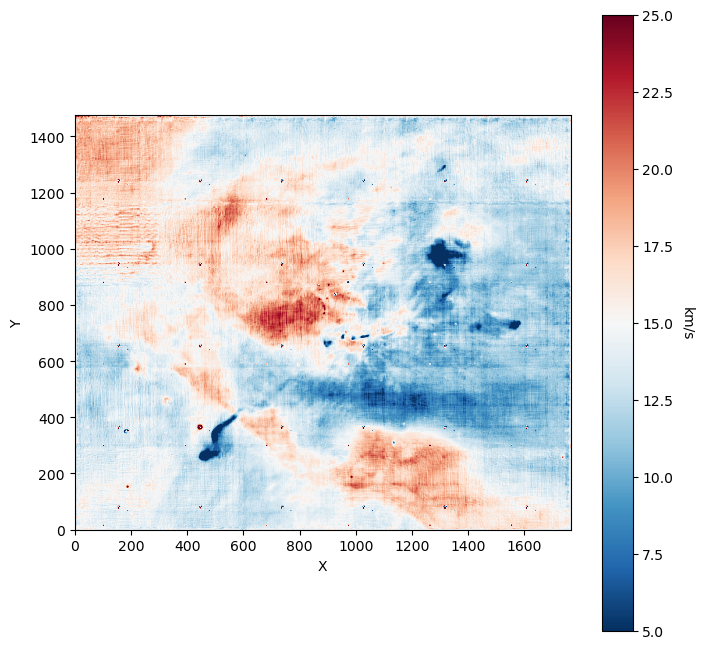

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(vv, cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(5,25)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [12]:
vv_df       = pd.DataFrame(vv)
data        = vv_df.stack().reset_index().rename(columns={'level_0':'X', 'level_1':'Y', 0:'RV'})
data['I']   = sb_df.I

In [13]:
data.describe()

,X,Y,RV,I
count,2.606616e+06,2.606616e+06,2.606616e+06,2.606616e+06
mean,7.375000e+02,8.825000e+02,1.407819e+01,7.155653e-02
std,4.260845e+02,5.098003e+02,5.572487e+00,6.145139e-02
min,0.000000e+00,0.000000e+00,-6.662371e+03,0.000000e+00
25%,3.687500e+02,4.410000e+02,1.220784e+01,3.062927e-02
50%,7.375000e+02,8.825000e+02,1.407636e+01,4.621635e-02
75%,1.106250e+03,1.324000e+03,1.602050e+01,9.968495e-02
max,1.475000e+03,1.765000e+03,2.162566e+03,1.000000e+00


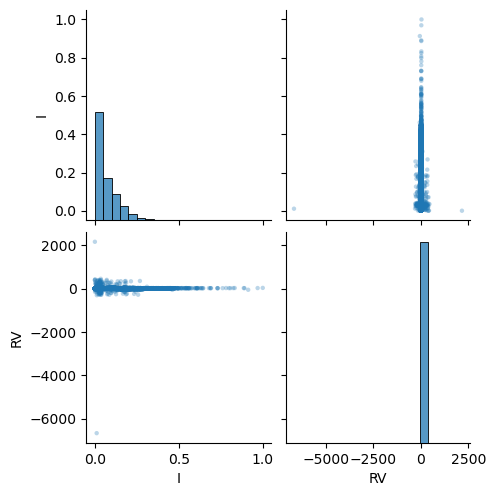

In [14]:
sns.pairplot(data, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [15]:
n = 2.0
mask = (data.I > 0.1) & (data.RV > data.RV.mean() - n*data.RV.std()) & (data.RV < data.RV.mean() + n*data.RV.std())

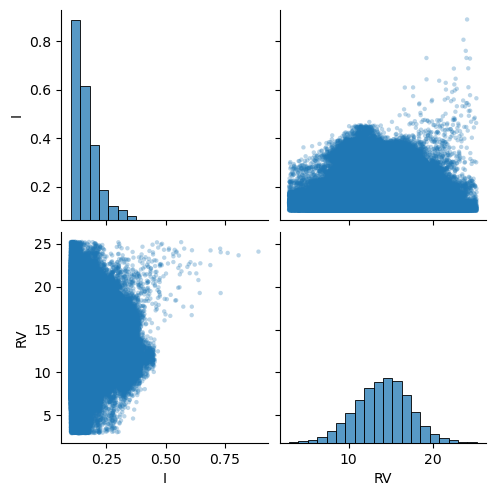

In [16]:
sns.pairplot(data[mask], 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )

In [17]:
data[mask].describe()

,X,Y,RV,I
count,644141.000000,644141.000000,644141.000000,644141.000000
mean,733.585783,899.302237,14.025364,0.161497
std,268.194828,246.872460,3.254406,0.052926
min,146.000000,184.000000,2.934357,0.100000
25%,526.000000,757.000000,11.895260,0.121733
50%,705.000000,925.000000,14.162725,0.147654
75%,943.000000,1082.000000,16.214207,0.186823
max,1355.000000,1734.000000,25.221740,0.890905


In [18]:
sb_mask = (data[mask].round(2)).pivot(index='Y', columns='X', values='I')
vv_mask = (data[mask].round(2)).pivot(index='Y', columns='X', values='RV')

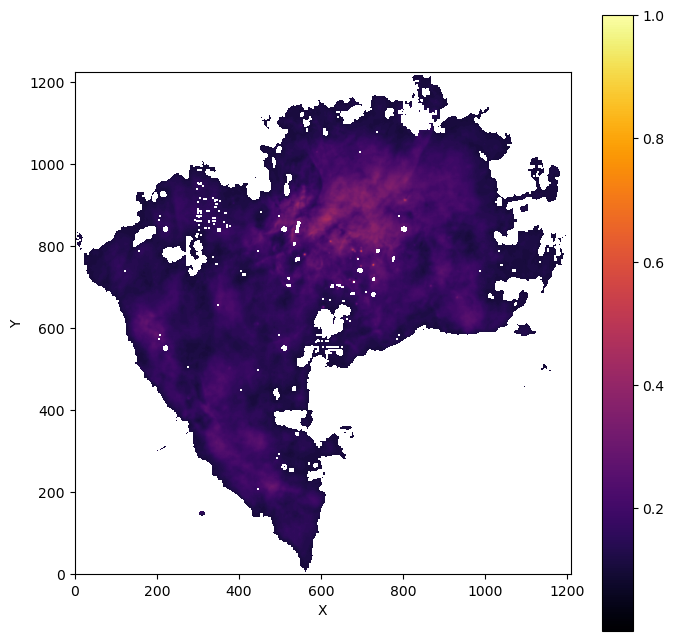

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.figure(1)
plt.imshow(sb_mask, cmap='inferno')

cbar = plt.colorbar()
plt.clim(0.001,1)
cbar.set_label(' ', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

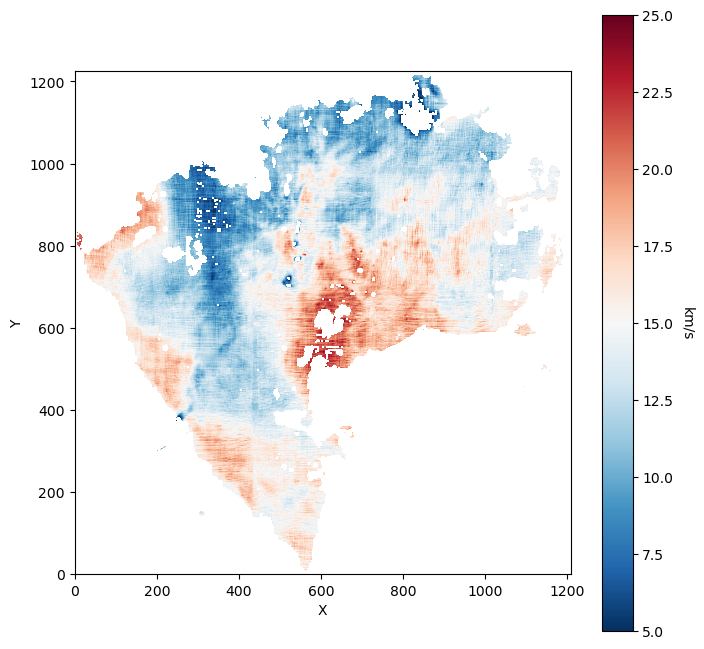

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))


plt.figure(1)
plt.imshow(vv_mask, cmap='RdBu_r')

cbar = plt.colorbar()
plt.clim(5,25)
cbar.set_label('km/s', rotation=270, labelpad=15)  

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.gca().invert_yaxis()

In [21]:
sb = np.array(sb_mask)
vv = np.array(vv_mask)

In [22]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
sb /= sb.max()

good = (~m) & (sb > 0.001)
box_size = np.sqrt(sb.shape[0] * sb.shape[1]) * pix * pc

In [23]:
data_export_matrix = {
       'name': name_export, 
       'pc' : pc,
       's0' : s0,
       'pix' : pix,
       'sb' : sb,
       'vv' : vv,
      }

data_export_matrix

{'name': 'H_I-6563_mask',
 'pc': 0.0019877360925490972,
 's0': 0.0007596443665792729,
 'pix': 0.2,
 'sb': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'vv': array([[14.02536083, 14.02536083, 14.02536083, ..., 14.02536083,
         14.02536083, 14.02536083],
        [14.02536083, 14.02536083, 14.02536083, ..., 14.02536083,
         14.02536083, 14.02536083],
        [14.02536083, 14.02536083, 14.02536083, ..., 14.02536083,
         14.02536083, 14.02536083],
        ...,
        [14.02536083, 14.02536083, 14.02536083, ..., 14.02536083,
         14.02536083, 14.02536083],
        [14.02536083, 14.02536083, 14.02536083, ..., 14.02536083,
         14.02536083, 14.02536083],
        [14.02536083, 14.02536083, 14.02536083, ..., 14.02536083,
         14.02536083, 14.02536083]])}

In [24]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

with open(name_export, "w") as f:
    json.dump(data_export_matrix, fp=f, indent=3, cls=MyEncoder)

In [25]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 71.41847681999207 seconds ---
